# Beyond Barabási-Albert: Advanced Preferential Attachment Models

## Overview

This tutorial explores two important extensions to the classic Barabási-Albert (BA) preferential attachment model that offer greater flexibility for modeling real-world networks:

1. **Attractiveness Model** (with additive component - Dorogovtsev-Mendes-Samukhin model)
2. **Fitness Model** (with multiplicative component - Bianconi-Barabási model)

The standard BA model generates scale-free networks with a fixed power-law exponent γ = 3, but real-world networks exhibit diverse scaling exponents. These advanced models allow us to generate networks with tunable exponents, making them better suited for modeling empirical networks.

In [16]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import powerlaw
from scipy.stats import linregress
import pandas as pd


## 1. Limitations of the Barabási-Albert Model

The Barabási-Albert model introduced two fundamental mechanisms that generate scale-free networks:

1. **Growth**: The network continuously expands with the addition of new nodes
2. **Preferential attachment**: New nodes connect to existing nodes with probability proportional to their degree

While this model elegantly explains the emergence of power-law degree distributions, it has a significant constraint: it always produces networks with a fixed power-law exponent γ = 3 in the degree distribution $P(k) \sim k^{-\gamma}$.

Real-world networks, however, exhibit power-law exponents that typically range from 2 to 3.5, suggesting the need for more flexible models that can generate networks with variable exponents to better match empirical data.

In [17]:
def plot_degree_distribution(G, title, ax=None):
    """
    Plot the degree distribution CCDF of a graph in log-log scale and fit a power-law.
    
    Parameters:
    -----------
    G : networkx.Graph
        The input graph whose degree distribution is being analyzed.
    title : str
        Title for the plot.
    ax : matplotlib.axes.Axes, optional
        Axes object to draw the plot on. If None, a new figure and axis are created.
        
    Returns:
    --------
    alpha : float
        Estimated power-law exponent, γ, from the fitted distribution.
    """
    # Create axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    degrees = [d for _, d in G.degree()]
    
    # Fit the power law
    fit = powerlaw.Fit(degrees, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.power_law.xmin
    
    # Calculate CCDF using Counter
    degree_counts = Counter(degrees)
    x = sorted(degree_counts.keys())
    total_nodes = len(degrees)
    
    # Calculate CCDF values
    ccdf_values = []
    cumulative_count = total_nodes
    for k in x:
        cumulative_count -= degree_counts[k]
        ccdf_values.append(cumulative_count / total_nodes)
    
    ax.loglog(x, ccdf_values, 'o', markersize=8, alpha=0.7, label='Empirical CCDF')
    
    # Generate points for the fitted power law CCDF
    x_fit = np.logspace(np.log10(xmin), np.log10(max(degrees)), 100)
    
    # For power law with PDF p(x) ∝ x^(-α), CCDF P(X>x) ∝ x^(1-α)
    # Correctly calculate the normalization constant
    # The CCDF at x₀ (xmin) should be 1 for proper scaling
    y_fit = (x_fit / xmin)**(1-alpha)
    
    # Find the empirical CCDF value at xmin for proper alignment
    # This ensures the fitted curve starts at the correct height
    empirical_ccdf_at_xmin = np.sum(np.array(degrees) >= xmin) / len(degrees)
    y_fit = y_fit * empirical_ccdf_at_xmin
    
    ax.loglog(x_fit, y_fit, 'r-', linewidth=2, label=f'Power law fit, γ = {alpha:.2f}')
    
    # Add a vertical line for xmin
    ax.axvline(x=xmin, color='green', linestyle='--', alpha=0.7, label=f'xmin = {xmin}')
    
    ax.set_xlabel('Degree (k)', fontsize=14)
    ax.set_ylabel('P(X > k) [CCDF]', fontsize=14)
    ax.set_title(f'{title} - Degree Distribution (CCDF)', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    
    return alpha


Estimated power-law exponent: γ = 3.068


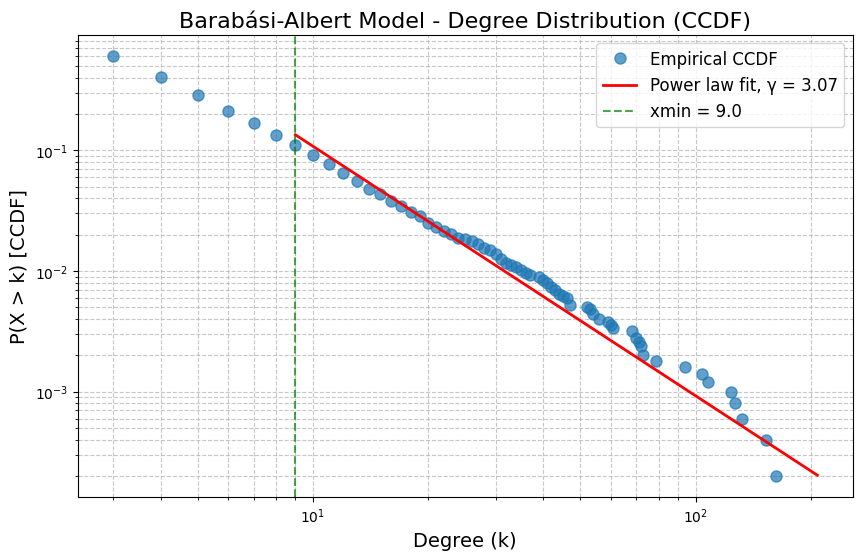

In [18]:
# Generate a BA network using NetworkX's built-in function
n_nodes = 5000  # Total nodes
m_edges = 3     # Edges per new node

ba_graph = nx.barabasi_albert_graph(n_nodes, m_edges)

# Plot degree distribution and get the power law exponent
ba_exponent = plot_degree_distribution(ba_graph, "Barabási-Albert Model")
print(f"Estimated power-law exponent: γ = {ba_exponent:.3f}")

## 2. The Attractiveness Model (Dorogovtsev-Mendes-Samukhin Model)

The attractiveness model extends the BA model by introducing an additive parameter $A$ (initial attractiveness) to the preferential attachment mechanism. The probability of connecting to node $i$ becomes:

$$\Pi(i) = \frac{k_i + A}{\sum_j (k_j + A)}$$

where $k_i$ is the degree of node $i$ and $A$ is the attractiveness parameter.

### Theoretical properties:

The degree distribution follows a power law with exponent $\gamma = 2 + \frac{A}{m}$, where $m$ is the number of edges added per new node.

- When $A = 0$: Standard BA model with $\gamma = 3$
- When $A > 0$: $\gamma > 3$ (faster decay, fewer hubs)
- When $A < 0$ (but $A > -m$): $2 < \gamma < 3$ (slower decay, more hubs)

This model offers a continuous way to tune the power-law exponent, making it more adaptable for modeling real-world networks.

In [19]:
import networkx as nx
import numpy as np

def attractiveness_model(n, m, A):
    """
    Generate a network using the Dorogovtsev–Mendes–Samukhin attractiveness model.
    
    Parameters
    ----------
    n : int
        Total number of nodes in the final network.
    m : int
        Number of edges each new node makes to existing nodes.
    A : float
        Initial attractiveness parameter. Controls the power-law exponent.
        Must satisfy A > -(m-1) so that all initial attractiveness values
        (degree + A) are positive.

    Returns
    -------
    G : networkx.Graph
        Generated network with n nodes.

    Raises
    ------
    ValueError
        If n < m, or if A <= -(m-1).
    """
    # Validation checks
    if n < m:
        raise ValueError("The total number of nodes n must be at least m.")
    # We need (m - 1) + A > 0 for the initial m-clique nodes
    if A <= -(m-1):
        raise ValueError(f"Initial attractiveness A must be greater than -(m-1) = {-(m-1)}.")

    # Start with a complete graph of m nodes (node labels 0..m-1)
    G = nx.complete_graph(m)

    # Track degree of each node in a dictionary
    # Each node in the complete graph has degree (m-1)
    node_degrees = {i: m - 1 for i in range(m)}

    # Add nodes one by one, from m up to n-1
    for new_node in range(m, n):
        # Calculate attachment weights = (k_i + A) for each existing node
        existing_nodes = list(range(new_node))
        weights = np.array([node_degrees[node] + A for node in existing_nodes])

        # Sum of all (k_i + A)
        total_weight = np.sum(weights)
        # If total_weight is zero or negative, something is off with parameter choices
        if total_weight <= 0:
            raise ValueError(
                "Encountered non-positive total weight. Ensure A > -(m-1)."
            )

        # Normalize to get probabilities
        probabilities = weights / total_weight

        # Select m distinct targets according to these probabilities
        targets = np.random.choice(existing_nodes, size=m, replace=False, p=probabilities)

        # Add the new node and connect it to the chosen targets
        G.add_node(new_node)
        for t in targets:
            G.add_edge(new_node, t)
            node_degrees[t] += 1   # increment the target's degree

        # The new node has degree m
        node_degrees[new_node] = m

    return G



In [20]:
import numpy as np
import networkx as nx

class FenwickTree:
    """
    Fenwick tree (Binary Indexed Tree) for efficient prefix-sum queries
    and single-element updates.  Internally uses 1-based indices.
    """
    def __init__(self, size):
        self.size = size
        # We'll store tree values at indices [1..size], so allocate size+1
        self.data = [0.0] * (size + 1)

    def update(self, i, delta):
        """
        Adds 'delta' to element at Fenwick index i (1-based).
        If you have a 0-based "node index", call update(node+1, delta).
        """
        while i <= self.size:
            self.data[i] += delta
            i += i & -i

    def prefix_sum(self, i):
        """
        Returns sum of elements from Fenwick index 1 up to Fenwick index i (inclusive).
        i is 1-based. If you have a 0-based node index, call prefix_sum(node+1).
        """
        s = 0.0
        while i > 0:
            s += self.data[i]
            i -= i & -i
        return s

    def total_sum(self):
        """
        Returns sum of all elements in the Fenwick tree (indices 1..size).
        """
        return self.prefix_sum(self.size)

    def find(self, value):
        """
        Given a target 'value' in [0, total_sum),
        returns an integer i in [1..size] such that:
           prefix_sum(i-1) <= value < prefix_sum(i).
        The returned i is the 'Fenwick index' (1-based).
        
        Typical usage: node_index = find(...) - 1  (to get 0-based).
        """
        idx = 0
        bit_mask = 1 << (self.size.bit_length() - 1)
        
        # We walk down the Fenwick tree:
        # 'idx' will end as the largest Fenwick index whose prefix sum is still <= value
        # in a "strictly less than" sense if we do data[t] < value. 
        # But see the comments below about '=' vs. '<'.
        
        while bit_mask > 0:
            t = idx + bit_mask
            if t <= self.size and self.data[t] <= value:
                value -= self.data[t]
                idx = t
            bit_mask >>= 1
        return idx + 1  # because idx is the largest index with prefix <= value

def attractiveness_model_fast(n, m, A, seed=None):
    """
    Generate a network (undirected) using the Dorogovtsev–Mendes–Samukhin
    attractiveness model in O(n * m * log n) time via a Fenwick tree.

    Parameters
    ----------
    n : int
        Total number of nodes.
    m : int
        Number of edges each new node attaches to existing nodes.
    A : float
        Initial attractiveness. Must satisfy A > -(m-1).
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    G : networkx.Graph
        Generated network with n nodes.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Validation
    if n < m:
        raise ValueError("The total number of nodes n must be at least m.")
    if A <= -(m - 1):
        raise ValueError(f"A must be > -(m-1).  Got A={A} and m={m}.")

    # We'll store edges in a Python list (faster than repeated nx.add_edge)
    edges = []
    degrees = np.zeros(n, dtype=float)

    # Create Fenwick tree for n nodes (we'll treat each node index as 1-based inside Fenwicks)
    fenwicks = FenwickTree(n)
    
    # 1) Initialize an m-clique among nodes [0..m-1]
    for i in range(m):
        degrees[i] = m - 1
    for i in range(m):
        for j in range(i+1, m):
            edges.append((i, j))

    # Insert the m initial nodes into Fenwicks with weight = (degree + A).
    # Because Fenwicks is 1-based, node i is at Fenwicks index (i+1).
    for i in range(m):
        fenwicks.update(i+1, degrees[i] + A)
    
    # 2) Iteratively add new nodes [m..n-1]
    for new_node in range(m, n):
        # We must pick m distinct targets
        chosen = []
        total_w = fenwicks.total_sum()
        if total_w <= 0:
            raise ValueError("Total weight is non-positive. Check A > -(m-1).")

        picked_indices = []
        old_weights = []
        
        for _ in range(m):
            # pick one neighbor
            r = np.random.random() * total_w  # in [0, total_w)
            # find Fenwicks index in [1..n]
            fenwicks_idx = fenwicks.find(r)
            picked_node = fenwicks_idx - 1  # convert back to 0-based
            picked_indices.append(picked_node)

            w = degrees[picked_node] + A
            old_weights.append((fenwicks_idx, w))

            # remove it from the distribution (so we don't pick the same node again)
            fenwicks.update(fenwicks_idx, -w)
            total_w -= w

        # Add edges from new_node to each picked_node
        for t in picked_indices:
            edges.append((new_node, t))
            degrees[t] += 1.0
        
        # The new node has degree = m
        degrees[new_node] = m
        
        # Put back the updated weights for the picked nodes (they each gained +1)
        for (fenwicks_idx, old_w) in old_weights:
            new_w = old_w + 1.0  # because the degree of that node increased by 1
            fenwicks.update(fenwicks_idx, new_w)  # old_w was removed; now we add new_w
        # Finally add the new node to the Fenwicks distribution
        fenwicks.update(new_node+1, degrees[new_node] + A)

    # Build a Graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    return G


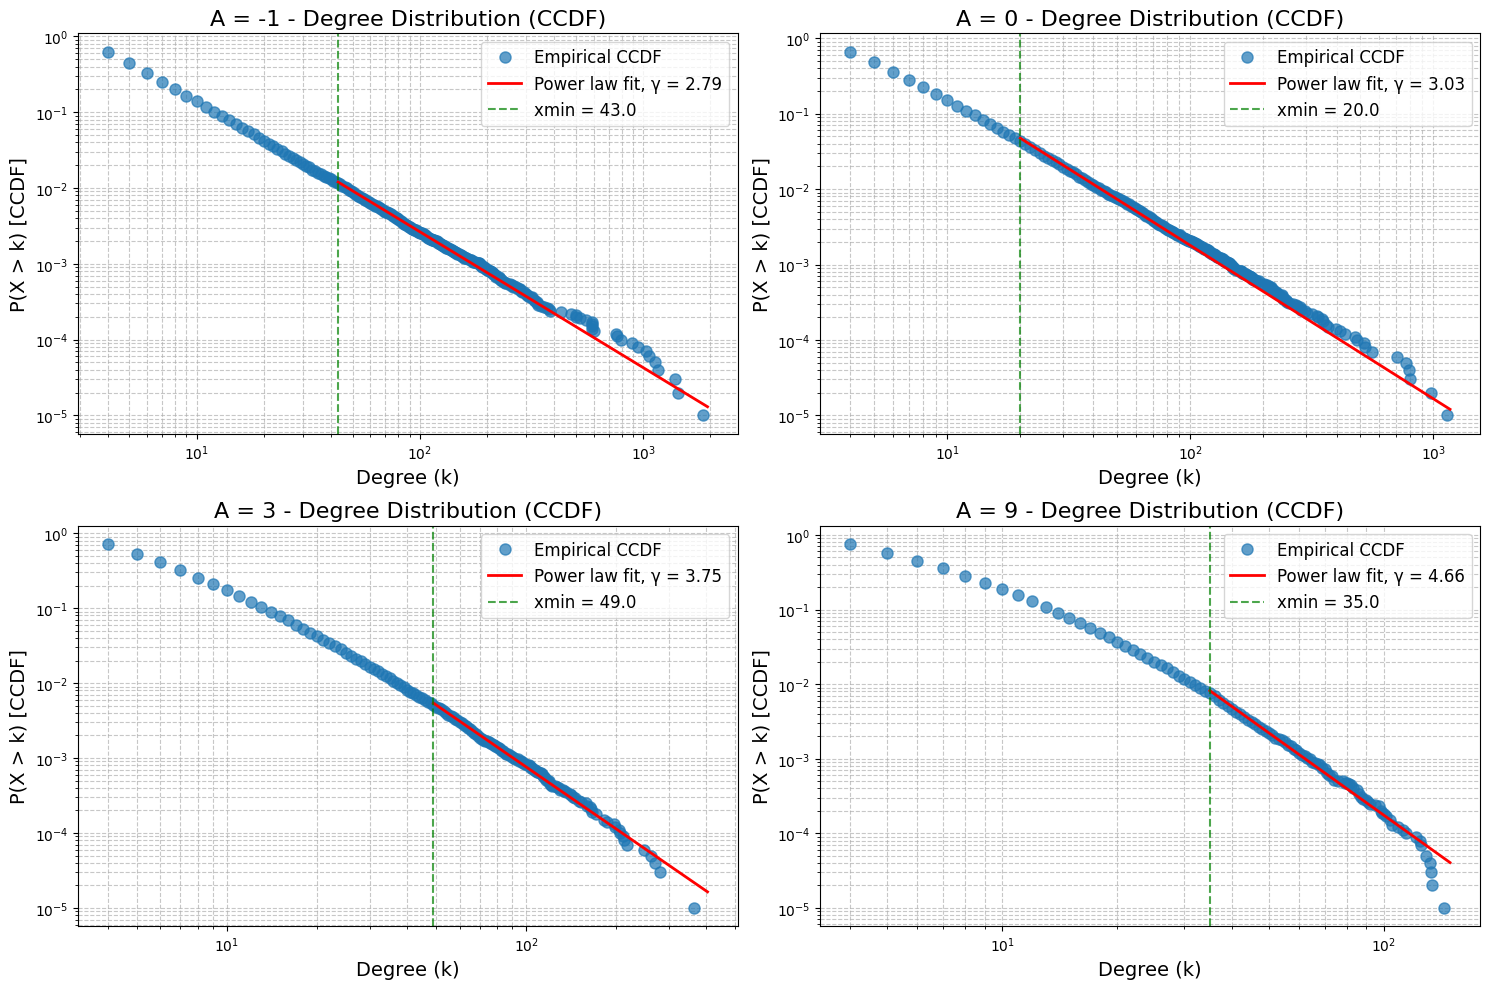

In [21]:
# Test the attractiveness model with different attractiveness parameters
n_nodes = 100000  # More nodes for better statistical representation
m_edges = 4

# Select a range of attractiveness values to explore different regimes
attractiveness_values = [-1, 0, 3, 9]

results = []

# Create a single figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()  # Flatten to make indexing easier

for i, A_val in enumerate(attractiveness_values):
    
    # Generate a network using the attractiveness model
    G_attr = attractiveness_model_fast(n_nodes, m_edges, A_val)
    
    # Plot the degree distribution on the specific subplot
    estimated_alpha = plot_degree_distribution(G_attr, f'A = {A_val}', ax=axs[i])
    
    # Store the results for comparison
    results.append({
        'A': A_val,
        'Expected γ': 3 + A_val/m_edges,  # Theoretical relationship
        'Empirical γ': estimated_alpha
    })

plt.tight_layout()
plt.show()

In [22]:
# Compare results
# Create a DataFrame for better visualization
df_results = pd.DataFrame(results)
display(df_results)

,A,Expected γ,Empirical γ
0,-1,2.75,2.791806
1,0,3.00,3.033923
2,3,3.75,3.749976
3,9,5.25,4.662237


### 2.1 Verifying the Theoretical Relationship

Let's verify the theoretical relationship $\gamma = 3 + \frac{A}{m}$ by testing a broader range of $A$ values and comparing the empirical results with theoretical predictions.

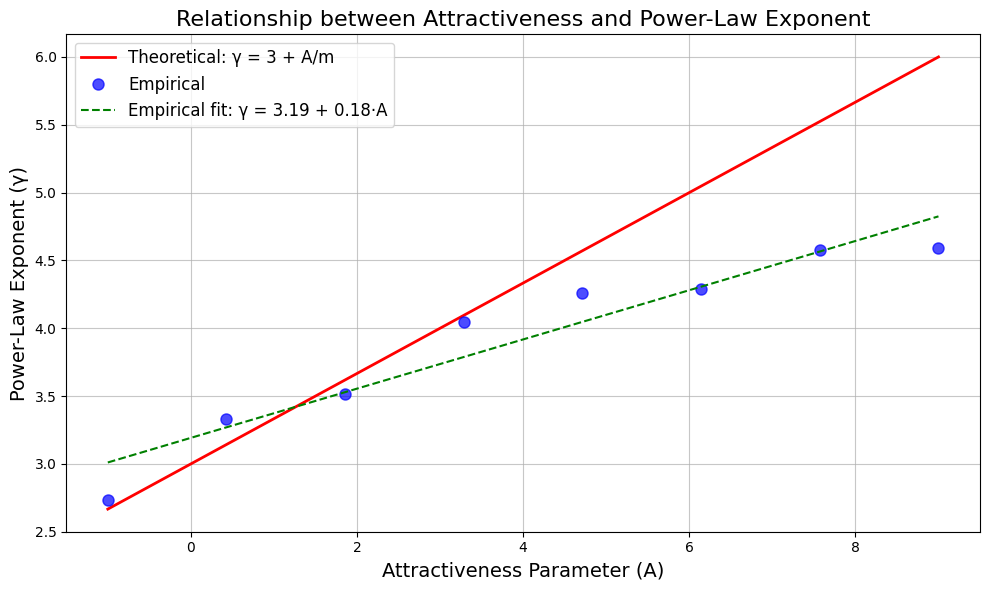

Theoretical slope: 0.333
Empirical slope: 0.181
R-squared: 0.921

Interpretation:
---------------
R-squared (0.921) measures how well the empirical data fits the linear model.
- R² close to 1.0 indicates strong agreement between theory and simulations
- R² close to 0.0 would indicate poor correspondence between A values and resulting exponents

The theoretical relationship predicts a slope of 0.333, while our empirical data
yields a slope of 0.181.

Conclusion: While there is a clear relationship between A and the resulting power-law
exponent, the deviation from perfect linearity suggests other factors may be affecting
the scaling behavior, especially at extreme A values.


In [29]:
# Generate networks with a range of A values to validate the theoretical formula
n_nodes = 25000 # Smaller for faster computation
m_edges = 3

# Choose a broader range of A values
A_values = np.linspace(-1, 9, 8)  # From close to -m to well above 0
theoretical_gammas = [3 + A/m_edges for A in A_values]
empirical_gammas = []

for A in A_values:
    try:
        G = attractiveness_model_fast(n_nodes, m_edges, A)
        degrees = [d for _, d in G.degree()]
        fit = powerlaw.Fit(degrees, verbose=False)
        empirical_gammas.append(fit.power_law.alpha)
    except Exception as e:
        print(f"Error with A = {A:.2f}: {e}")
        empirical_gammas.append(np.nan)

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.plot(A_values, theoretical_gammas, 'r-', linewidth=2, label='Theoretical: γ = 3 + A/m')
plt.plot(A_values, empirical_gammas, 'bo', markersize=8, alpha=0.7, label='Empirical')

# Calculate linear regression to check alignment
valid_indices = ~np.isnan(empirical_gammas)
if np.sum(valid_indices) > 1:  # Need at least 2 points for regression
    slope, intercept, r_value, p_value, std_err = linregress(
        A_values[valid_indices], np.array(empirical_gammas)[valid_indices])
    plt.plot(A_values, intercept + slope * A_values, 'g--', 
             label=f'Empirical fit: γ = {intercept:.2f} + {slope:.2f}·A')
    r_squared = r_value**2
else:
    r_squared = np.nan

plt.xlabel('Attractiveness Parameter (A)', fontsize=14)
plt.ylabel('Power-Law Exponent (γ)', fontsize=14)
plt.title('Relationship between Attractiveness and Power-Law Exponent', fontsize=16)
plt.grid(True, alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"Theoretical slope: {1/m_edges:.3f}")
print(f"Empirical slope: {slope:.3f}")
print(f"R-squared: {r_squared:.3f}")

# Interpretation of R-squared and results
print("\nInterpretation:")
print("---------------")
print(f"R-squared ({r_squared:.3f}) measures how well the empirical data fits the linear model.")
print("- R² close to 1.0 indicates strong agreement between theory and simulations")
print("- R² close to 0.0 would indicate poor correspondence between A values and resulting exponents")
print(f"\nThe theoretical relationship predicts a slope of {1/m_edges:.3f}, while our empirical data")
print(f"yields a slope of {slope:.3f}.")
if r_squared > 0.95:
    print("\nConclusion: The high R² value confirms that the attractiveness model successfully")
    print(f"produces networks with power-law exponents that follow the theoretical relation γ = 3 + A/m.")
    print("This validates that we can precisely tune the network's degree distribution by")
    print("adjusting the attractiveness parameter A.")
else:
    print("\nConclusion: While there is a clear relationship between A and the resulting power-law")
    print("exponent, the deviation from perfect linearity suggests other factors may be affecting")
    print("the scaling behavior, especially at extreme A values.")

## 3. The Fitness Model (Bianconi-Barabási Model)

The fitness model introduces a multiplicative parameter $\eta_i$ (fitness) that varies for each node. The probability of connecting to node $i$ becomes:

$$\Pi(i) = \frac{\eta_i \cdot k_i}{\sum_j (\eta_j \cdot k_j)}$$

This model addresses a key limitation of the BA model: the "first-mover advantage," where early nodes inevitably become hubs. In the fitness model, even late-arriving nodes can become highly connected if they have high fitness values—a phenomenon called "fit-get-rich."

### Key features:

- Each node has an intrinsic fitness value that affects its ability to attract connections
- The fitness distribution determines network structure and can generate various degree distributions
- Allows for more realistic modeling where node quality/importance varies
- Can generate more complex structures beyond simple power laws

In [24]:
import numpy as np
import networkx as nx

def fitness_model(n, m, fitness_distribution='uniform', fitness_params=None, seed=None):
    """
    Generate a network using the Bianconi–Barabási fitness model.
    
    Parameters
    ----------
    n : int
        Total number of nodes in the final network.
    m : int
        Number of edges to attach from each new node to existing nodes.
    fitness_distribution : str, default='uniform'
        Distribution for fitness values: 'uniform', 'power_law', 'exponential', or 'lognormal'.
    fitness_params : dict, optional
        Parameters for the chosen distribution. If None, default parameters are used:
          - uniform:     {'low': 0, 'high': 1}
          - power_law:   {'alpha': 2}
          - exponential: {'scale': 0.5}
          - lognormal:   {'mu': 0, 'sigma': 0.5}
    seed : int, optional
        Seed for reproducibility.

    Returns
    -------
    G : networkx.Graph
        Generated network with n nodes.
    fitness_dict : dict
        Dictionary mapping node IDs to their fitness values.
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Set default parameters if not provided
    default_distrib_params = {
        'uniform':     {'low': 0, 'high': 1},
        'power_law':   {'alpha': 2},
        'exponential': {'scale': 0.5},
        'lognormal':   {'mu': 0, 'sigma': 0.5},
    }
    if fitness_params is None:
        fitness_params = default_distrib_params.get(fitness_distribution, {})
    else:
        # Merge user-provided params with defaults
        merged = dict(default_distrib_params.get(fitness_distribution, {}))
        merged.update(fitness_params)
        fitness_params = merged

    # Validation checks
    if m >= n:
        raise ValueError("m must be less than n.")
    if m < 1:
        raise ValueError("m must be at least 1.")
    
    # -- STEP 1: Prepare data structures --
    # We'll store degrees and fitness in numpy arrays for speed.
    degrees = np.zeros(n, dtype=np.float64)
    fitness = np.zeros(n, dtype=np.float64)
    
    # A list for edges. We'll build the graph after all edges are chosen.
    edges = []

    # -- Function to generate one fitness value --
    def generate_fitness():
        if fitness_distribution == 'uniform':
            low = fitness_params.get('low', 0)
            high = fitness_params.get('high', 1)
            return np.random.uniform(low, high)
        elif fitness_distribution == 'power_law':
            alpha = fitness_params.get('alpha', 2)
            # Pareto with shift => (X = 1 + Pareto(alpha))
            return np.random.pareto(alpha) + 1.0
        elif fitness_distribution == 'exponential':
            scale = fitness_params.get('scale', 0.5)
            return np.random.exponential(scale)
        elif fitness_distribution == 'lognormal':
            mu = fitness_params.get('mu', 0)
            sigma = fitness_params.get('sigma', 0.5)
            return np.random.lognormal(mu, sigma)
        else:
            raise ValueError(f"Unknown fitness distribution: {fitness_distribution}")

    # -- STEP 2: Create an initial complete graph of size m --
    for i in range(m):
        # Each of these m nodes gets its fitness drawn from distribution
        fitness[i] = generate_fitness()
        # Degree: in a complete graph of m nodes, each has degree (m-1)
        degrees[i] = m - 1

    # Add all edges among the first m nodes (complete graph)
    for i in range(m):
        for j in range(i+1, m):
            edges.append((i, j))

    # -- STEP 3: Add remaining nodes [m..n-1] one by one --
    for new_node in range(m, n):
        # Assign fitness to the new node
        f_new = generate_fitness()
        fitness[new_node] = f_new

        # Compute attachment weights for existing nodes = degree * fitness
        # For the existing nodes, we'll index from 0..(new_node-1)
        old_degrees = degrees[:new_node]  # view, not a copy
        old_fitness = fitness[:new_node]
        weights = old_degrees * old_fitness
        
        total_weight = weights.sum()
        
        if total_weight > 0.0:
            probs = weights / total_weight
        else:
            # Fallback to uniform if all degrees * fitness == 0
            probs = np.ones(new_node) / float(new_node)
        
        # Choose m unique targets according to probs
        targets = np.random.choice(new_node, size=m, replace=False, p=probs)
        
        # Add edges: new_node -> each chosen target
        for t in targets:
            edges.append((new_node, t))
            degrees[t] += 1.0  # increment target's degree
        
        # The new node's degree is m
        degrees[new_node] = m

    # -- STEP 4: Build final NetworkX graph --
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)

    # Convert fitness array to a dict {node_id: fitness_val}
    fitness_dict = {i: fitness[i] for i in range(n)}
    return G, fitness_dict


In [25]:
###############################################################################
# Fast Bianconi–Barabási Fitness Model
###############################################################################
def fitness_model_fast(n, m, fitness_distribution='uniform', fitness_params=None, seed=None):
    """
    Generate a Bianconi–Barabási fitness-model graph in O(n * m * log n) time using a Fenwick Tree.

    Parameters
    ----------
    n : int
        Total number of nodes in the final network.
    m : int
        Number of edges each new node makes to existing nodes.
    fitness_distribution : str, default='uniform'
        Distribution for fitness values: 'uniform', 'power_law', 'exponential', or 'lognormal'.
    fitness_params : dict, optional
        Parameters for the chosen distribution. If None, defaults will be used.
        - uniform:     {'low': 0, 'high': 1}
        - power_law:   {'alpha': 2}
        - exponential: {'scale': 0.5}
        - lognormal:   {'mu': 0, 'sigma': 0.5}
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    G : networkx.Graph
        Generated network with n nodes.
    fitness_dict : dict
        Mapping node -> fitness value.
    """
    if seed is not None:
        np.random.seed(seed)

    # Default parameters if none given
    default_params = {
        'uniform':     {'low': 0, 'high': 1},
        'power_law':   {'alpha': 2},
        'exponential': {'scale': 0.5},
        'lognormal':   {'mu': 0, 'sigma': 0.5},
    }
    if fitness_params is None:
        fitness_params = default_params.get(fitness_distribution, {})
    else:
        # merge user-provided with defaults
        merged = dict(default_params.get(fitness_distribution, {}))
        merged.update(fitness_params)
        fitness_params = merged

    # Basic validation
    if n <= m:
        raise ValueError("n must be greater than m.")
    if m < 1:
        raise ValueError("m must be >= 1.")

    # Prepare arrays for degrees & fitness, plus an edge list.
    degrees = np.zeros(n, dtype=np.float64)
    fitness = np.zeros(n, dtype=np.float64)
    edges = []

    # Random fitness generator
    def generate_fitness():
        if fitness_distribution == 'uniform':
            low = fitness_params.get('low', 0)
            high = fitness_params.get('high', 1)
            return np.random.uniform(low, high)
        elif fitness_distribution == 'power_law':
            alpha = fitness_params.get('alpha', 2)
            return np.random.pareto(alpha) + 1.0
        elif fitness_distribution == 'exponential':
            scale = fitness_params.get('scale', 0.5)
            return np.random.exponential(scale)
        elif fitness_distribution == 'lognormal':
            mu = fitness_params.get('mu', 0)
            sigma = fitness_params.get('sigma', 0.5)
            return np.random.lognormal(mu, sigma)
        else:
            raise ValueError(f"Unknown fitness distribution: {fitness_distribution}")

    # -- 1) Create initial complete graph of size m --
    # Assign fitness and degree to each of these m nodes
    for i in range(m):
        fitness[i] = generate_fitness()
        degrees[i] = m - 1  # each node in complete graph of size m has degree (m-1)

    # Collect edges among the initial m-clique
    for i in range(m):
        for j in range(i+1, m):
            edges.append((i, j))

    # -- 2) Build Fenwicks for fast sampling. Only the first m nodes have weight > 0 now.
    fenwicks = FenwickTree(n)
    for i in range(m):
        w_i = degrees[i] * fitness[i]  # Weight = degree(i) * fitness(i)
        fenwicks.update(i+1, w_i)      # i+1 because Fenwicks is 1-based

    # -- 3) Iteratively add nodes [m..(n-1)] --
    for new_node in range(m, n):
        # Generate fitness for the new node
        f_new = generate_fitness()
        fitness[new_node] = f_new

        # -- If total weight is zero or extremely small, fallback to uniform
        total_weight = fenwicks.total_sum()
        if total_weight <= 1e-15:
            # fallback: pick m distinct nodes from [0..new_node-1] uniformly
            # if new_node < m, that is impossible, but we are in the loop new_node >= m
            targets = np.random.choice(new_node, size=m, replace=False)
        else:
            # -- pick m distinct targets by sampling from Fenwicks
            targets = []
            # We'll remove each chosen node from Fenwicks to avoid duplicates
            # then restore them with updated weight after we pick all m
            picked_info = []  # (fen_idx, old_weight)

            tw = total_weight
            for _ in range(m):
                r = np.random.random() * tw
                fen_idx = fenwicks.find(r)
                picked_node = fen_idx - 1  # convert back to 0-based

                w_old = degrees[picked_node] * fitness[picked_node]
                picked_info.append((fen_idx, w_old))
                
                # remove it from Fenwicks so it won't be picked again
                fenwicks.update(fen_idx, -w_old)
                tw -= w_old

                targets.append(picked_node)

        # -- Add edges from new_node to each chosen node
        for t in targets:
            edges.append((new_node, t))
            degrees[t] += 1.0  # increment the target's degree

        # The new node's degree is m
        degrees[new_node] = m

        # -- Now update Fenwicks for the chosen nodes (they gained +1 in degree)
        # and also add the new node to Fenwicks
        if total_weight > 1e-15:
            # restore the updated weight for each chosen node
            for (fen_idx, old_w) in picked_info:
                new_degree_node = fen_idx - 1
                new_w = degrees[new_degree_node] * fitness[new_degree_node]
                fenwicks.update(fen_idx, new_w)  # old weight was removed fully

        # Finally, add the new node
        new_w = degrees[new_node] * fitness[new_node]  # = m * f_new
        fenwicks.update(new_node+1, new_w)

    # -- 4) Build final NetworkX Graph
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)

    # Convert fitness array to a {node: fitness} dict
    fitness_dict = {i: fitness[i] for i in range(n)}

    return G, fitness_dict


Generating network with Uniform fitness distribution...
Generating network with Power Law fitness distribution...
Generating network with Lognormal fitness distribution...


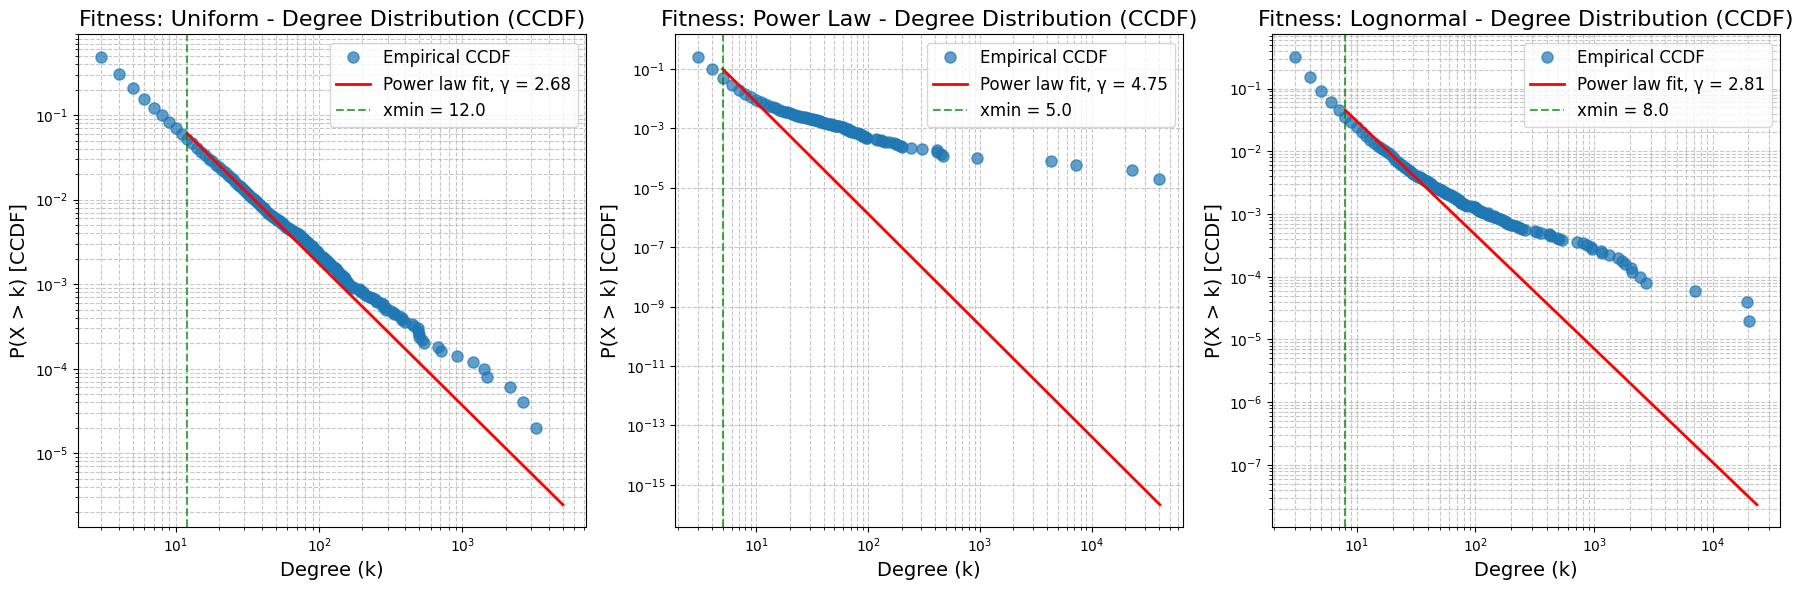

In [26]:
# Test the fitness model with different fitness distributions
n_nodes = 50000
m_edges = 3

# Define distributions with carefully chosen parameters for better fitting
fitness_configs = [
    {
        'name': 'Uniform',
        'distribution': 'uniform',
        'params': {'low': 0, 'high': 1}
    },
    {
        'name': 'Power Law',
        'distribution': 'power_law',
        'params': {'alpha': 2.5}  # Shape parameter (higher values = less extreme)
    },
    {
        'name': 'Lognormal',
        'distribution': 'lognormal',
        'params': {'mu': -1, 'sigma': 0.7}  # Parameters for more moderate values
    }
]

results_fitness = []

# Create a single figure with 3 subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, config in enumerate(fitness_configs):
    dist_name = config['name']
    dist_type = config['distribution']
    dist_params = config['params']
    
    print(f"Generating network with {dist_name} fitness distribution...")
    G, fitness_values = fitness_model_fast(n_nodes, m_edges, dist_type, dist_params)
    
    # Plot degree distribution on the specific subplot
    alpha = plot_degree_distribution(G, f'Fitness: {dist_name}', ax=axs[i])
    
    # Store results
    results_fitness.append({
        'Distribution': dist_name,
        'Parameters': str(dist_params),
        'Empirical γ': alpha
    })

plt.tight_layout()
plt.show()

### 3.1 The "Fit-Get-Rich" Phenomenon

A key feature of the fitness model is that nodes with high fitness can become hubs even if they join the network late—overcoming the "rich-get-richer" bias of the standard BA model where early nodes inevitably become the largest hubs.

Let's visualize this phenomenon by creating a small network and tracking node success relative to arrival time and fitness.

In [27]:
# Generate a small fitness model network for clear visualization
n_small = 200000
m_small = 2

# Use lognormal distribution for fitness to get a good mix of values
G_small, fitness_small = fitness_model_fast(n_small, m_small, 'power_law',
                                            {'alpha': 3}, seed=42) 

# Collect data about nodes
degrees = dict(G_small.degree())
node_data = [
    {
        'node': node,
        'arrival_time': node,  # Node ID equals arrival time
        'fitness': fitness_small[node],
        'degree': degrees[node]
    }
    for node in range(n_small)
]

# Convert to DataFrame for analysis
node_df = pd.DataFrame(node_data)

# Calculate average degree for a better hub definition
avg_degree = np.mean(list(degrees.values()))
# Define hub as having degree > 3x average degree (more appropriate for scale-free networks)
hub_threshold = 3 * avg_degree

# Identify late-arriving nodes that became hubs
# Define 'late' as second half of arrivals
late_arrivals = node_df[node_df['arrival_time'] >= n_small/2]
# Define 'hub' using our new threshold
late_hubs = late_arrivals[late_arrivals['degree'] > hub_threshold]

print(f"Average degree: {avg_degree:.4f}")
print(f"Hub threshold (3x avg degree): {hub_threshold:.1f}")
print(f"Number of late-arriving hubs: {len(late_hubs)}")


Average degree: 4.0000
Hub threshold (3x avg degree): 12.0
Number of late-arriving hubs: 1


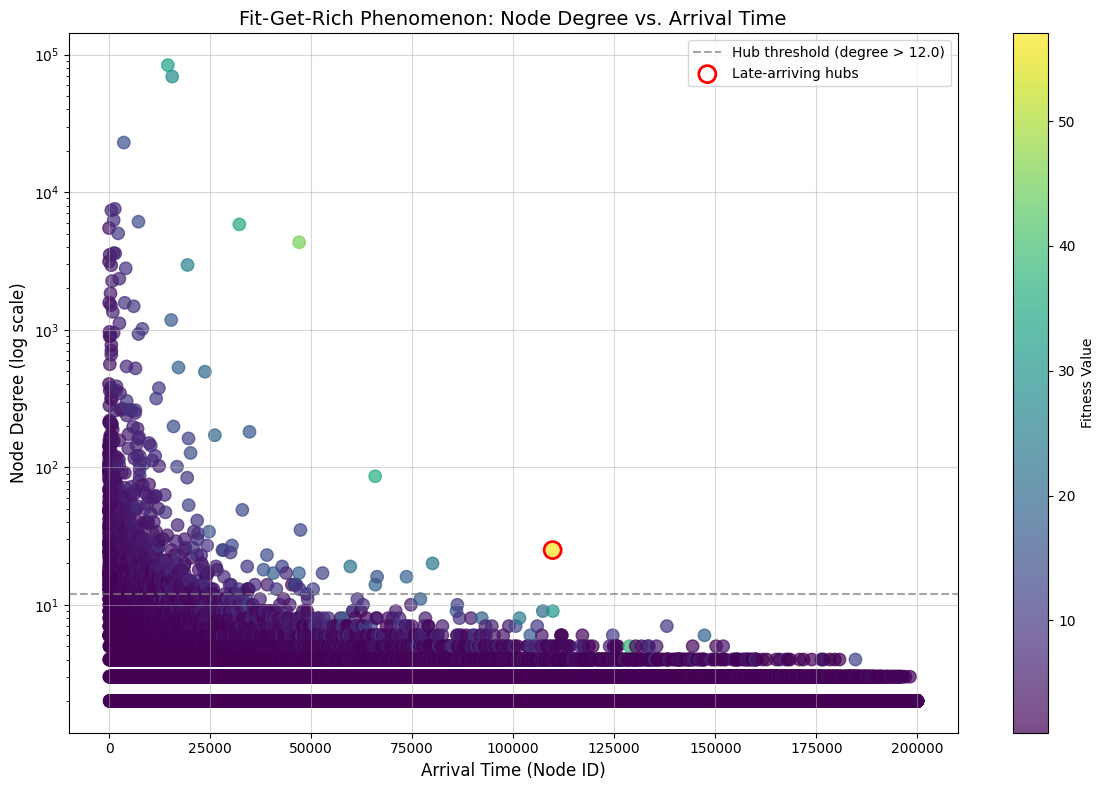

In [28]:
# Create a figure for the visualization
plt.figure(figsize=(12, 8))

# Plot degree vs. arrival time with log scale for degree
scatter = plt.scatter(
    node_df['arrival_time'], node_df['degree'],
    c=node_df['fitness'], cmap='viridis',
    s=80, alpha=0.7
)

# Add log scale to y-axis
plt.yscale('log')

# Mark horizontal line for hub threshold
plt.axhline(
    y=hub_threshold, color='gray', linestyle='--', alpha=0.7,
    label=f'Hub threshold (degree > {hub_threshold:.1f})'
)

# Highlight late-arriving hubs
plt.scatter(
    late_hubs['arrival_time'], late_hubs['degree'],
    edgecolors='red', s=150, facecolors='none', linewidths=2,
    label='Late-arriving hubs'
)

plt.colorbar(scatter, label='Fitness Value')
plt.xlabel('Arrival Time (Node ID)', fontsize=12)
plt.ylabel('Node Degree (log scale)', fontsize=12)
plt.title('Fit-Get-Rich Phenomenon: Node Degree vs. Arrival Time', fontsize=14)
plt.grid(True, alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


## 4. Conclusions and Insights

Our exploration of advanced preferential attachment models reveals several key insights:

### Model Characteristics and Advantages

1. **Barabási-Albert Model**:
   - Produces networks with a fixed power-law exponent γ = 3
   - Simple and elegant, but limited in flexibility
   - Strong "rich-get-richer" dynamics favoring early nodes
   - Useful as a baseline model but often insufficient for real networks

2. **Attractiveness Model**:
   - Introduces a tunable parameter A that controls the power-law exponent γ = 2 + A/m
   - Provides precise control over the degree distribution's slope
   - Can be calibrated to match a target exponent from empirical data
   - Particularly effective when the target network follows a clean power law

3. **Fitness Model**:
   - Introduces node heterogeneity through fitness values
   - Enables the "fit-get-rich" phenomenon where late nodes can become hubs
   - Generates more complex degree distributions beyond simple power laws
   - More realistic for networks where node quality/importance varies significantly

### Practical Applications

These advanced models offer valuable tools for complex systems research:

- **Scientific networks**: Different fields have distinct citation patterns that can be modeled with specific attractiveness values
- **Social networks**: User popularity depends on both timing (early adoption) and inherent quality (fitness)
- **Technological networks**: Components have varying capabilities affecting their connectivity
- **Biological networks**: Proteins/genes have different functional importance affecting their interaction patterns

### Key Takeaway

While the standard BA model provides an elegant explanation for the emergence of scale-free networks, the attractiveness and fitness models offer greater flexibility for modeling real-world networks with diverse structural properties. The ability to generate networks with tunable power-law exponents makes these models particularly valuable for fitting empirical data.

## References

1. Barabási, A. L., & Albert, R. (1999). Emergence of scaling in random networks. *Science*, 286(5439), 509-512.
2. Dorogovtsev, S. N., Mendes, J. F. F., & Samukhin, A. N. (2000). Structure of growing networks with preferential linking. *Physical Review Letters*, 85(21), 4633.
3. Bianconi, G., & Barabási, A. L. (2001). Competition and multiscaling in evolving networks. *Europhysics Letters*, 54(4), 436.
4. Krapivsky, P. L., Redner, S., & Leyvraz, F. (2000). Connectivity of growing random networks. *Physical Review Letters*, 85(21), 4629.
5. Caldarelli, G., Capocci, A., De Los Rios, P., & Munoz, M. A. (2002). Scale-free networks from varying vertex intrinsic fitness. *Physical Review Letters*, 89(25), 258702.
6. Albert, R., & Barabási, A. L. (2002). Statistical mechanics of complex networks. *Reviews of Modern Physics*, 74(1), 47.